# Attribution init

In [1]:
#load datasets
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ok
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok
firepolygon = gpd.read_parquet('../data/processed_datasets/simplified_firepolygons_2017_2020_FR_EPSG2154.parquet') #ok

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:
firepolygon['class'] = 'Fire'
#add end date with offset of 7 days 
firepolygon['end_date'] = pd.to_datetime(firepolygon['start_date']) + pd.to_timedelta(7, unit='d')
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms, 'firepolygons':firepolygon}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'firepolygons': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'firepolygons': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 50}),
        'temporal': ('offset_gaussian', {'offset': 7, 'decrease': 31})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': .75, 'bdiff': 1.0, 'cdi':.75, 'forms':0.75, 'firepolygons':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100, 'firepolygons':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 124.78 km2, median : 24.99 km2


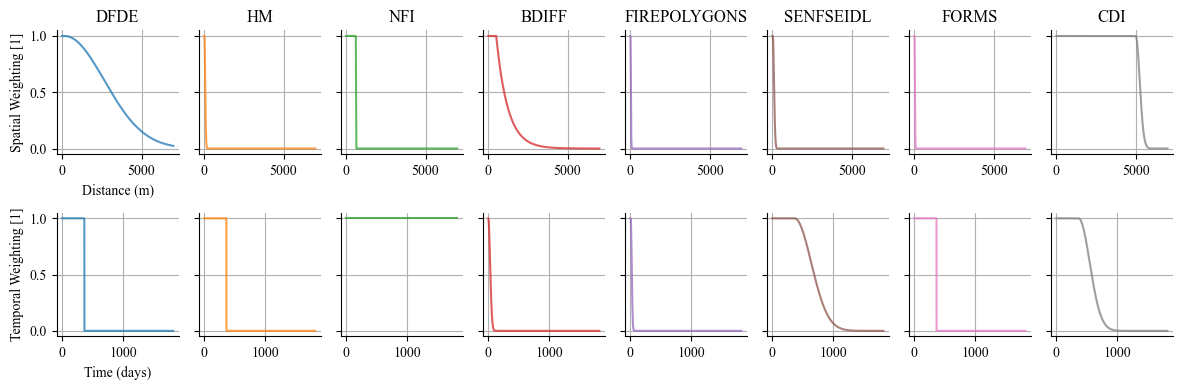

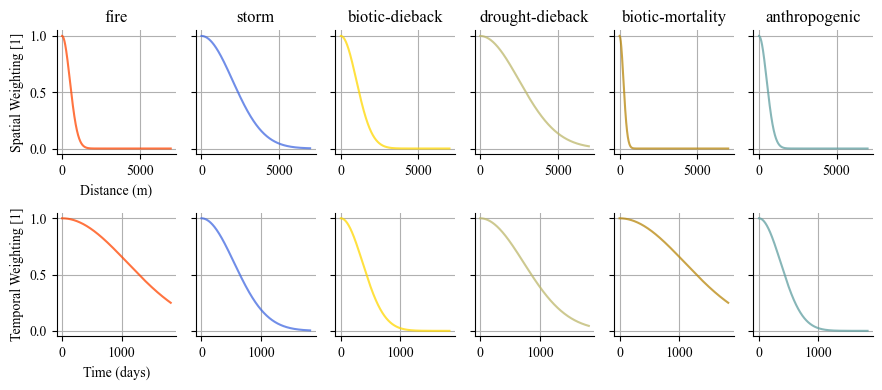

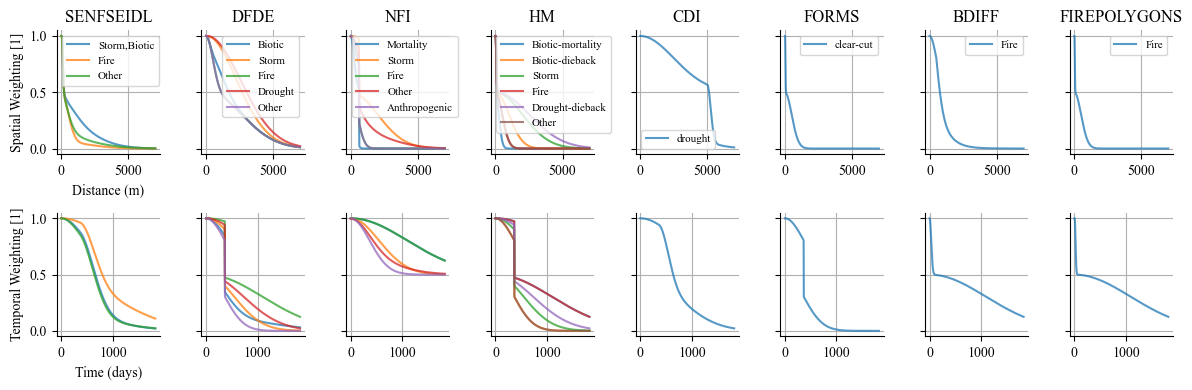

(<Figure size 1200x400 with 16 Axes>,
 <Figure size 900x400 with 12 Axes>,
 <Figure size 1200x400 with 16 Axes>)

In [7]:
attribution.plot_weighting_functions()

# Experience 1 : Louvain resolution 

Paramètre à tester pour chaque expérience:

Composition de la mesure de similarité selon 3 configurations:
- PCA
- unitaire
- ecologique 
Comparaison de la qualité du clustering : indice de Davies-Bouldin
Comparaison de la resistance au bruit : AMI, ARI 

Montrer qu'un clustering en deux étapes est nécessaire : 
- Communauté de Louvain avec similarité composée via 'unitaire' et résolution poussée au max. 

Influence des paramètres de DBSCAN sur la qualité du clustering et du bruit : 
- eps 
- min_samples


## Communauté de Louvain

Taille des communautés en utilisant une similarité équi-composée avec les 4 distances. 

In [33]:
from utils import is_temporally_similar, compute_class_similarity
import networkx as nx
import numpy as np
from tqdm import tqdm 

def build_graph(dataset_loc, dataset_glob,  sindex, spatial_threshold, temporal_threshold, attribution, G=None):
    
    if G is None:
        G = nx.Graph()
        # Construct the similarity matrix using spatial index
    for event1 in tqdm(dataset_loc.itertuples(index=True)):
        i = event1.Index
        # Find nearby events within spatial threshold
        possible_matches_index = list(sindex.intersection(event1.geometry.buffer(spatial_threshold).bounds))
        possible_matches = dataset_glob.iloc[possible_matches_index]

        for event2 in possible_matches.itertuples(index=True):
            j = event2.Index
            if i != j and is_temporally_similar(event1, event2, temporal_threshold):
                ds = event1.geometry.centroid.distance(event2.geometry.centroid)
                dt = abs(event1.centroid_date - event2.centroid_date).days 
                we = compute_tree_coherence(event1, event2, filter_class, attr_class='_3')
                wc = compute_class_similarity(event1, event2, attribution.dclass_score, attr_class='_3')
                ws = np.mean([attribution.final_weighting_dict[event1.dataset][event1._3]['spatial'](ds), attribution.final_weighting_dict[event2.dataset][event2._3]['spatial'](ds)])
                wt = np.mean([attribution.final_weighting_dict[event1.dataset][event1._3]['temporal'](dt), attribution.final_weighting_dict[event2.dataset][event2._3]['temporal'](dt)])
                G.add_edge(i, j, ws=ws, wt=wt, we=we, wc=wc)
    
    return G 

from thefuzz import fuzz 
def compute_tree_coherence(row1 : pd.Series, row2 : pd.Series, filter_class : dict, attr_class='class') -> float:
    """Compute the tree coherence between two rows

    Args:
        row1 (pd.Series): first row
        row2 (pd.Series): second row

    Returns:
        float: tree coherence
    """
    if getattr(row1, attr_class) in filter_class and getattr(row2, attr_class) in filter_class:
        return 1.
    
    for essence1 in row1.essence.split(','):
        for essence2 in row2.essence.split(','):
            if fuzz.token_set_ratio(essence1.lower(), essence2.lower()) > 80:
                return 1
        
    if row1.tree_type.lower() == row2.tree_type.lower():
        return 0.75 
    
    if row1.tree_type.lower() == 'mixed' or row2.tree_type.lower() == 'mixed':
        return 0.5

    return 0.25 

from typing import Dict
def compute_class_similarity(row1 : pd.Series, row2 : pd.Series, dclass_score : Dict[str, Dict[str, Dict[str, float]]], attr_class = 'class' ) -> float:
    """Compute the similarity between two classes

    Args:
        row1 (pd.Series): first row
        row2 (pd.Series): second row
        dclass_score (Dict[str, Dict[str, Dict[str, float]]]): dictionary containing the class scores
    
    Returns:
        float: similarity score
    """

    # If both classes are from the same dataset and have the same class, return 1.0
    if row1.dataset == row2.dataset and getattr(row1, attr_class) == getattr(row2, attr_class):
        return 1.0

    # Get the score dictionaries for the two classes
    scores1 = dclass_score.get(row1.dataset, {}).get(getattr(row1, attr_class), {})
    scores2 = dclass_score.get(row2.dataset, {}).get(getattr(row2, attr_class), {})
    
    # Find common final classes between the two classes
    common_final_classes = set(scores1.keys()).intersection(set(scores2.keys()))
    
    # Calculate the sum of the means of the scores for each common final class
    similarity_score = sum((scores1[final_class] + scores2[final_class]) / 2 for final_class in common_final_classes)
    
    return similarity_score

#DCLASS_SCORE is a dict (dataset) of dict (class) of dict (sub-classs) of dict (value)
#GET ALL class of DCLASS_SCORE if they have a sub-class in ['storm', 'fire']
# you need to loop into dataset and then into class 
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)

In [23]:
mode = 'equal'
dim = 2
WEIGHTS_ECO = list({'ws': 2, 'wt': 1.5, 'we': 1, 'wc': 2}.values())
WEIGHTS_PCA = list({'ws': 0.40759976, 'wt': 0.23017731, 'we': 0.20566699, 'wc': 0.15655594}.values())

In [26]:
from utils import is_temporally_similar, get_temporal_range
from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))

_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
temporal_threshold = 180 * 2
spatial_threshold = 600
print(n, m)
import os 
from tqdm import tqdm 
import networkx as nx 
b = "_".join([str(x) for x in bounds_4326])

temporal_threshold_ = temporal_threshold 
spatial_threshold_ = spatial_threshold



dataset = _dataset[['geometry', 'dataset', 'class', 'centroid_date', 'essence', 'tree_type']]
dataset.fillna('Unknown', inplace=True)
spatial_entity_dataset = _spatial_entity_dataset[['geometry', 'centroid_date', 'essence', 'tree_type']]
spatial_entity_dataset.fillna('Unknown', inplace=True)
sindex = dataset.sindex
spatial_entity_sindex = spatial_entity_dataset.sindex

if os.path.isfile(f"../data/results/graph/graph_d{dim}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.gml"):
    G = nx.read_gml(f"../data/results/graph/graph_d{dim}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.gml")

else: 
    # Assuming gdf is your GeoDataFrame
    print('Building graph...')
    G = nx.Graph()
    dataset_loc = dataset
    #while graph not connected build graph by doubling thresholds
    N = 3
    i = 0
    while (len(G) == 0 or not nx.is_connected(G)) and (i < N or len(dataset_loc) > 0):
        G = build_graph(dataset_loc, dataset, sindex, spatial_threshold, temporal_threshold, attribution, G=G)
        spatial_threshold *= 2
        temporal_threshold *= 2
        print(f'graph not connected, new thresholds : {spatial_threshold}m, {temporal_threshold}d')
        #set d as the dataset with the events not in the graph
        dataset_loc = dataset[~dataset.index.isin(G.nodes())]
        i += 1
    
    nx.write_gml(G, f"../data/results/graph/graph_d{dim}_g{attribution.granularity}_{spatial_threshold_}_{temporal_threshold_}_{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.gml")

#add one attribute to all edges
for u, v, d in G.edges(data=True):
    if dim == 4:
        lweights = [d['ws'], d['wt'], d['we'], d['wc']]
    elif dim == 2:
        lweights = [d['ws'], d['wt']]
    if mode == 'equal':
        d['weight'] = np.mean(lweights)
    elif mode == 'PCA':
        d['weight'] = np.average(lweights, weights=WEIGHTS_PCA[:dim])
    elif mode == 'eco':
        d['weight'] = np.average(lweights, weights=WEIGHTS_ECO[:dim])

# islands = list(nx.connected_components(G))
for resolution in [10, 50, 100, 150, 200]:
    communities = nx.community.louvain_communities(G, seed=0, resolution=resolution)

    # Create a list to store the sub-GeoDataFrames
    island_gdfs = []

    print(f'Building islands with resolution {resolution}...')
    # Iterate over each island and create a sub-GeoDataFrame
    for island in tqdm(communities):
        # Select rows from the original GeoDataFrame that correspond to the current island
        island_gdf = attribution.dataset.iloc[list(island)]
        
        # Append this sub-GeoDataFrame to the list
        island_gdfs.append(island_gdf)

    for i, island_gdf in tqdm(enumerate(island_gdfs)):
        # Calculate the envelope (bounding box) of the cluster
        envelope = island_gdf.unary_union.envelope

        # Calculate the temporal range of the cluster
        cluster_start, cluster_end = get_temporal_range(island_gdf)

        # Find potential matches using spatial index
        possible_matches_index = list(spatial_entity_sindex.intersection(envelope.bounds))
        possible_matches = spatial_entity_dataset.iloc[possible_matches_index]

        if len(possible_matches_index) > 0 :
            break
        # Initialize an empty list to store events to be added
        events_to_add = []

        # Iterate through each potential match
        for event in possible_matches.itertuples(index=True):
            # Check spatial intersection
            spatial_condition = envelope.intersects(event.geometry)
            # Check temporal intersection
            event_start = event.start_date  # Replace with your actual column name
            event_end = event.end_date
            temporal_condition = ((event_start <= cluster_end + temporal_threshold) and (event_end >= cluster_end - temporal_threshold)) or ((event_start <= cluster_start + temporal_threshold) and (event_end >= cluster_start - temporal_threshold)) 

            # If both conditions are met, add the event to the list
            if spatial_condition and temporal_condition:
                events_to_add.append(event.Index)

        # Add the events to the cluster GeoDataFrame
        if len(events_to_add) > 0:
            additional_events = attribution.spatial_entity_dataset.loc[events_to_add]
            island_gdfs[i] = gpd.GeoDataFrame(pd.concat([island_gdf, additional_events]), geometry='geometry', crs=island_gdf.crs)
    
    # Initialize an empty list to store the modified cluster GeoDataFrames          
    modified_gdfs = []

    # Add a 'cluster' column and concatenate
    for i, island_gdf in tqdm(enumerate(island_gdfs)):
        island_gdf['cluster'] = i  # Add a 'cluster' column with the cluster index
        modified_gdfs.append(island_gdf)


    # Ensure the GeoDataFrame has the correct geometry set
    all_clusters_gdf = gpd.GeoDataFrame(pd.concat(modified_gdfs), geometry='geometry').drop(columns=['year'])

    # Save to GeoParquet
    c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
    all_clusters_gdf.to_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")

    print(f'conversion rate : {c :.2%}')

    ##metrics##
    island_sizes = all_clusters_gdf.cluster.value_counts().tolist()
    median = np.median(island_sizes)
    std = np.std(island_sizes)
    print(f'median : {median}, std : {std}')

    if os.path.isfile('records.parquet'):
        old = gpd.read_parquet('records.parquet')
    else : 
        old = None

    #prepare a pandas dataframe with all the columns for all the parameters : 
    columns = ['geometry', 'version', 'spatial_threshold', 'temporal_threshold', 'n', 'm', 'c', 'resolution', 'communities_similarity', 'communities_mode', 'communities_size_median', 'communities_size_std', 'sigma_noise_spatial', 'sigma_noise_temporal', 'clustering_method', 'clustering_method_params', 'clustering_similarity', 'clustering_mode', 'davies-bouldin_median', 'davies-bouldin_std', 'AMI', 'ARI']
    row1 = {'geometry': pol_4326, 'version': attribution.version, 'spatial_threshold': spatial_threshold_, 'temporal_threshold': temporal_threshold_, 'n': n, 'm': m, 'c': c, 'resolution': resolution, 'communities_similarity': f'{dim}d', 'communities_mode': mode, 'communities_size_median': median, 'communities_size_std': std, 'sigma_noise_spatial': 0, 'sigma_noise_temporal': 0, 'clustering_method': 'louvain', 'clustering_method_params': None, 'clustering_similarity': None, 'clustering_mode':None,  'davies-bouldin_median': None, 'davies-bouldin_std': None, 'AMI': None, 'ARI': None}
    gdf = gpd.GeoDataFrame([row1], columns=columns, geometry='geometry', crs='epsg:2154')

    if old is not None:
        gdf = gpd.GeoDataFrame(pd.concat([old, gdf]), columns=columns, geometry='geometry', crs='epsg:2154').reset_index(drop=True)
    #save the dataframe
    gdf.to_parquet(f"records.parquet")

8.351448773231649 2.5036109773712085
Building graph...


63274it [06:13, 169.26it/s]


graph not connected, new thresholds : 1200m, 720d


6883it [00:41, 166.21it/s]


graph not connected, new thresholds : 2400m, 1440d


1023it [00:07, 130.97it/s]


graph not connected, new thresholds : 4800m, 2880d


5it [00:00, 124.77it/s]


graph not connected, new thresholds : 9600m, 5760d
Building islands with resolution 10...


100%|██████████| 2558/2558 [00:05<00:00, 462.91it/s]
3it [00:00, 108.06it/s]
2558it [00:00, 4761.74it/s]


conversion rate : 99.84%
median : 5.0, std : 41.61933939084472
Building islands with resolution 50...


100%|██████████| 3238/3238 [00:06<00:00, 533.33it/s]
0it [00:00, ?it/s]
3238it [00:00, 4958.80it/s]


conversion rate : 99.84%
median : 7.0, std : 23.250562281483898
Building islands with resolution 100...


100%|██████████| 3709/3709 [00:08<00:00, 431.77it/s]
0it [00:00, ?it/s]
3709it [00:00, 4862.35it/s]


conversion rate : 99.84%
median : 9.0, std : 17.4255867488069
Building islands with resolution 150...


100%|██████████| 4072/4072 [00:07<00:00, 526.19it/s]
0it [00:00, ?it/s]
4072it [00:00, 5102.50it/s]


conversion rate : 99.84%
median : 9.0, std : 14.45200604486936
Building islands with resolution 200...


100%|██████████| 4390/4390 [00:08<00:00, 522.82it/s]
0it [00:00, ?it/s]
4390it [00:00, 5026.39it/s]


conversion rate : 99.84%
median : 10.0, std : 12.699904343020236


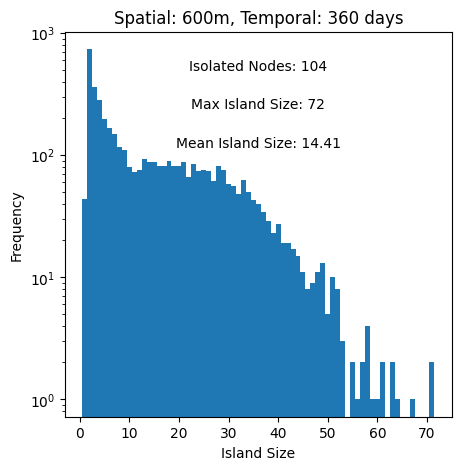

In [27]:
island_sizes = all_clusters_gdf.cluster.value_counts().tolist()
isolated_nodes = _spatial_entity_dataset.shape[0] + _dataset.shape[0] - all_clusters_gdf.shape[0]
import matplotlib.pyplot as plt 
import numpy as np 

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.hist(island_sizes, bins=range(1, max(island_sizes) + 1), align='left', log=True)
ax.set_title(f"Spatial: {spatial_threshold_}m, Temporal: {temporal_threshold_} days")
ax.set_xlabel('Island Size')
ax.set_ylabel('Frequency')
ax.annotate(f'Isolated Nodes: {isolated_nodes}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
ax.annotate(f'Max Island Size: {max(island_sizes)}', xy=(0.5, 0.8), xycoords='axes fraction', ha='center')
ax.annotate(f'Mean Island Size: {np.mean(island_sizes):.2f}', xy=(0.5, 0.7), xycoords='axes fraction', ha='center')
fig.savefig(f'../data/results/clusters/communities_d4_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.png', dpi=200)

In [30]:
records = gpd.read_parquet('records.parquet')
a = records[records['communities_similarity'] == '2d'][['resolution', 'communities_size_median', 'communities_size_std']].sort_values(by='resolution')
#a to markdown without index
#print line by line
print(a.to_markdown(index=False))

|   resolution |   communities_size_median |   communities_size_std |
|-------------:|--------------------------:|-----------------------:|
|           10 |                         5 |                41.6193 |
|           50 |                         7 |                23.2506 |
|          100 |                         9 |                17.4256 |
|          150 |                         9 |                14.452  |
|          200 |                        10 |                12.6999 |


# Experience 2 : similarity weighting

- Robustess au bruit spatial des 3 configurations de similarité 
- Calcul de AMI et ARI par rapport au bruit nul 
- Calcul de l'indice de Davies-Bouldin pour chaque configuration et chaque bruit 



In [17]:
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


In [ ]:
#1 calcul des matrices de similarités
#2 calcul de la matrice selon le mode 
#3 clustering 

In [2]:
from thefuzz import fuzz 
#import namedtuple
from collections import namedtuple
import numpy as np 
def build_temporal_matrix_v2(data, final_weighting_dict):

    #temporal
    start_date_matrix = data['start_date'].values.astype('datetime64[D]').reshape(-1, 1)
    day_diff_matrix_sd = np.abs((start_date_matrix - start_date_matrix.T) / np.timedelta64(1, 'D'))
  
    end_date_matrix = data['end_date'].values.astype('datetime64[D]').reshape(-1, 1)
    day_diff_matrix_ed = np.abs((end_date_matrix - end_date_matrix.T) / np.timedelta64(1, 'D'))

    m = (day_diff_matrix_sd + day_diff_matrix_ed)/2

    n = len(data)
    rows = list(data.itertuples(index=False))
    for i in range(n):
        for j in range(i + 1, n):
            weight = (final_weighting_dict[rows[i].dataset][rows[i].cause]['temporal'](m[i][j]) + final_weighting_dict[rows[j].dataset][rows[j].cause]['temporal'](m[j][i]))/2
            m[i][j] = weight
            m[j][i] = weight

    #fill diagonal with 1
    np.fill_diagonal(m, 1)

    # return  np.array(list(map(lambda row: list(map(f, row)), m)))
    return m 

def compute_tree_coherence_v2(row1 : namedtuple, row2 : namedtuple, filter_cause : dict) -> float:
    """Compute the tree coherence between two rows

    Args:
        row1 (namedtuple): first row
        row2 (namedtuple): second row

    Returns:
        float: tree coherence
    """
    if row1.cause in filter_cause and row2.cause in filter_cause:
        return 1.
    
    for essence1 in row1.essence.split(','):
        for essence2 in row2.essence.split(','):
            if fuzz.token_set_ratio(essence1.lower(), essence2.lower()) > 80:
                return 1
        
    if row1.tree_type.lower() == row2.tree_type.lower():
        return 0.75 
    
    if row1.tree_type.lower() == 'mixed' or row2.tree_type.lower() == 'mixed':
        return 0.5

    return 0.25 

from typing import Dict
def compute_class_similarity_v2(row1 : namedtuple, row2 : namedtuple, dclass_score : Dict[str, Dict[str, Dict[str, float]]], attr_class = 'class' ) -> float:
    """Compute the similarity between two classes

    Args:
        row1 (namedtuple): first row
        row2 (namedtuple): second row
        dclass_score (Dict[str, Dict[str, Dict[str, float]]]): dictionary containing the class scores
    
    Returns:
        float: similarity score
    """

    # If both classes are from the same dataset and have the same class, return 1.0
    if row1.dataset == row2.dataset and row1.cause == row2.cause:
        return 1.0

    # Get the score dictionaries for the two classes
    scores1 = dclass_score.get(row1.dataset, {}).get(row1.cause, {})
    scores2 = dclass_score.get(row2.dataset, {}).get(row2.cause, {})
    
    # Find common final classes between the two classes
    common_final_classes = set(scores1.keys()).intersection(set(scores2.keys()))
    
    # Calculate the sum of the means of the scores for each common final class
    similarity_score = sum((scores1[final_class] + scores2[final_class]) / 2 for final_class in common_final_classes)
    
    return similarity_score

def compute_spatial_distance_v2(row1 : namedtuple, row2 : namedtuple, final_weighting_dict: Dict[str, dict]) -> float:
    """Compute the spatial distance between two rows

    Args:
        row1 (namedtuple): first row
        row2 (namedtuple): second row

    Returns:
        float: spatial distance
    """
    distance = row1.geometry.centroid.distance(row2.geometry.centroid)
    # Convert distance to similarity
    weight = (final_weighting_dict[row1.dataset][row1.cause]['spatial'](distance) + final_weighting_dict[row2.dataset][row2.cause]['spatial'](distance))/2
    return weight

from typing import Callable
def build_custom_matrix_v2(df : pd.DataFrame, custom_similarity_function : Callable, kwargs: dict) -> np.ndarray:
    """Build a similarity matrix using a custom similarity function

    Args:
        df (pd.DataFrame): DataFrame containing the data to be compared
        custom_similarity_function (Callable): custom similarity function
        kwargs (dict): optional arguments for the custom similarity function

    Returns:
        np.ndarray: similarity matrix
    """

    n = len(df)
    # Initialize the similarity matrix with zeros
    similarity_matrix = np.zeros((n, n))

    # Convert DataFrame to a list of tuples for more efficient row access
    rows = list(df.itertuples(index=False))
    
    # Iterate over each pair of rows
    for i in range(n):
        for j in range(i+1, n):  # Use range(i, n) to avoid redundant computations
            # Compute the tree coherence for each pair of rows
            similarity = custom_similarity_function(rows[i], rows[j], **kwargs)
            # Fill in the matrix, it's symmetric so we can do both i,j and j,i
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    np.fill_diagonal(similarity_matrix, 1)

    return similarity_matrix

from typing import Dict, Tuple, Callable, List
from utils import build_spatial_matrix, build_temporal_matrix, build_custom_matrix


def get_matrices_v2(data : pd.DataFrame, dtypes_: Dict[str, str], dcustom_similarity_function : Dict[str, Tuple[Callable, dict]], final_weighting_dict : Dict[str, dict]) \
    -> List[np.ndarray]:
    """Compute all the different similarity matrices and combine them into a single matrix

    Args:
        data (pd.DataFrame): DataFrame containing the data to be compared
        dtypes_ (Dict[str, str]): dictionary of dataset types
        dcustom_similarity_function (Dict[str, Tuple[Callable, dict, float]]): Dictionary containing the custom similarity functions, the optional arguments and the weight associated with each function
        final_weighting_dict (Dict[str, dict]): dictionary containing the final weighting functions for each dataset and class

    Returns:
        List[np.ndarray]: list of similarity matrices : temporal, spatial, custom
    """

    #spatial 
    data = data.fillna('None')
    matrices = {}

    #temporal
    matrices['temporal'] = np.nan_to_num(build_temporal_matrix_v2(data, final_weighting_dict=final_weighting_dict), nan=0).clip(0,1)

    #CUSTOM  SIMILARITY FACTORS
    for name, (custom_function, kwargs) in dcustom_similarity_function.items():
        matrices[name] = np.nan_to_num(build_custom_matrix_v2(data, custom_function, kwargs), nan=0).clip(0,1)

    return list(matrices.values()) 

def get_matrices(data : gpd.GeoDataFrame, dtypes_: Dict[str, str], dcustom_similarity_function : Dict[str, Tuple[Callable, dict]], final_weighting_dict : Dict[str, dict]) \
    -> List[np.ndarray]:
    """Compute all the different similarity matrices and combine them into a single matrix

    Args:
        data (gpd.GeoDataFrame): GeoDataFrame containing the data to be compared
        dtypes_ (Dict[str, str]): dictionary of dataset types
        dcustom_similarity_function (Dict[str, Tuple[Callable, dict, float]]): Dictionary containing the custom similarity functions, the optional arguments and the weight associated with each function
        final_weighting_dict (Dict[str, dict]): dictionary containing the final weighting functions for each dataset and class

    Returns:
        List[np.ndarray]: list of similarity matrices
    """    
    
    data = data.fillna('None')
    matrices = {}
    #temporal
    matrices['temporal'] = np.nan_to_num(build_temporal_matrix(data, final_weighting_dict=final_weighting_dict), nan=0).clip(0,1)

    #spatial 
    matrices['spatial'] = np.nan_to_num(build_spatial_matrix(data, dtypes_=dtypes_, final_weighting_dict=final_weighting_dict), nan=0).clip(0,1)
    #CUSTOM  SIMILARITY FACTORS
    for name, (custom_function, kwargs) in dcustom_similarity_function.items():
        matrices[name] = np.nan_to_num(build_custom_matrix(data, custom_function, kwargs), nan=0).clip(0,1)

    return list(matrices.values()) 

def build_similarity_v2(matrices : List[np.ndarray], weights : List[float]) -> np.ndarray:
    """Combine the different similarity matrices into a single matrix

    Args:
        matrices (List[np.ndarray]): list of similarity matrices
        weights (List[float]): list of weights for each matrix

    Returns:
        np.ndarray: combined similarity matrix
    """

    return np.average(matrices, axis=0, weights=weights)

### Test de rapidité

speed up by 15x with v2

In [75]:
all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}
dcustom_similarity_function = {'tree_coherence': (compute_tree_coherence, {'filter_class': filter_class}), 
                               'class_similarity': (compute_class_similarity, {'dclass_score': DCLASS_SCORE})}
groups_v2 = all_clusters_gdf_v2.groupby('cluster')
groups = all_clusters_gdf.groupby('cluster')

from itertools import islice
lg = []
for name, group in islice(groups, 100):
    lg.append(group)

lg_v2 = []
for name, group in islice(groups_v2, 100):
    lg_v2.append(group)

In [76]:
len(lg[1])

52

In [81]:
%%time 
t2, s2, tc2, c2 = get_matrices_v2(lg_v2[0], dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict)

CPU times: user 60 ms, sys: 3.52 ms, total: 63.6 ms
Wall time: 66.1 ms


In [82]:
%%time 
t, s, tc, c = get_matrices(lg[0], dtypes, dcustom_similarity_function, attribution.final_weighting_dict)

CPU times: user 610 ms, sys: 10.6 ms, total: 621 ms
Wall time: 633 ms


<Axes: >

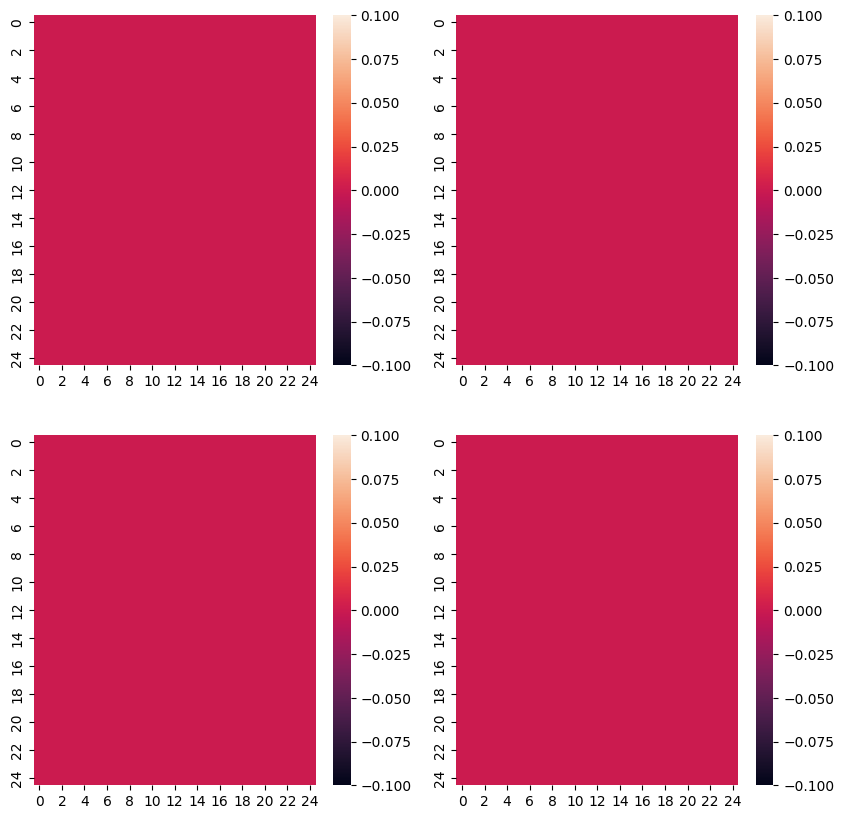

In [83]:
#compare matrix a to a2 and so on with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.heatmap(t-t2, ax=ax[0,0])
sns.heatmap(s-s2, ax=ax[0,1])
sns.heatmap(tc-tc2, ax=ax[1,0])
sns.heatmap(c-c2, ax=ax[1,1])


In [87]:
%%time
import warnings
from joblib import Parallel, delayed
with warnings.catch_warnings():   
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_matrices)(data,  dtypes, dcustom_similarity_function, attribution.final_weighting_dict) for data in lg)

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/3125343645.py:169: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/3125343645.py:169: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/3125343645.py:169: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by Geom

CPU times: user 1.44 s, sys: 299 ms, total: 1.74 s
Wall time: 32.7 s


In [92]:
%%time
import warnings
from joblib import Parallel, delayed
list_matrices = []
with warnings.catch_warnings():   
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    r2 = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_matrices_v2)(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict) for data in lg_v2)
    list_matrices.extend(r2)

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/3125343645.py:143: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/3125343645.py:143: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/3125343645.py:143: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by Geom

CPU times: user 886 ms, sys: 36.4 ms, total: 922 ms
Wall time: 1.62 s


/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/3125343645.py:143: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.


In [104]:
matrices = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(build_similarity_v2)(m, [1,1,1,1]) for m in list_matrices)

In [113]:
list_clusters = []
method = 'DBSCAN'
for i in tqdm(range(0, len(lg_v2), 1000)):
    r = Parallel(n_jobs=-1, prefer='processes', verbose=1)(delayed(get_cluster_v2)(data, m, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method) for data, m in zip(islice(lg_v2, i, min(len(lg_v2), i+1000)), islice(matrices, i, min(len(matrices), i+1000))))
    list_clusters.extend(r)

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/2978320579.py:105: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/2978320579.py:105: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/2978320579.py:105: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/2978320579.py:105: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/2978320579.py:105: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_1301/2978320579.py:105: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd5

### Running experiment

In [8]:
from typing import Dict, Tuple
from sklearn.cluster import SpectralClustering, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from utils import  get_predominant_class, calculate_temporal_centroid

def get_temporal_period_v2(cluster : gpd.GeoDataFrame, final_weighting_dict : Dict[str, dict]) -> (tuple, Tuple[pd.Timestamp, pd.Timestamp], float):

    if len(cluster) == 1:
        return None, (cluster['start_date'].iloc[0], cluster['end_date'].iloc[0]), 1.0
    else :
        upper_bound = 2 * 365 + abs(cluster['start_date'].min() - cluster['end_date'].max()).days
        # Determine the overall time range for the cluster
        start_date = cluster['start_date'].min() - pd.Timedelta(days=upper_bound)
        end_date = cluster['end_date'].max() + pd.Timedelta(days=upper_bound)
        time_range = pd.date_range(start=start_date, end=end_date, freq='2W')

        # Initialize an array to hold the sum of profiles
        sum_profiles = np.zeros(len(time_range))

        for event in cluster.itertuples():
            temporal_profile = final_weighting_dict[event.dataset][event.cause]['temporal']
            centroid_date = calculate_temporal_centroid(event.start_date, event.end_date)

            # Days difference from each point in the time range to the centroid
            days_from_centroid = (time_range - centroid_date).days

            # Evaluate the temporal profile
            evaluated_profile = np.array([temporal_profile(abs(day)) for day in days_from_centroid])

            # Accumulate the sum
            sum_profiles += evaluated_profile

        # Average the profiles
        average_profile = sum_profiles / len(cluster)

        # Plotting
        # Assuming 'average_profile' is your array and 'time_range' is your corresponding time axis

        # Find the index of the maximum value in the average profile (peak)
        peak_index = np.argmax(average_profile)
        confidence_threshold = np.percentile(average_profile, 90)
        # Initialize variables to store the desired x-axis values
        x_val_left = None
        x_val_right = None

        # Search to the left of the peak
        for i in range(peak_index, -1, -1):  # Iterate backwards from the peak
            if average_profile[i] <= confidence_threshold:
                x_val_left = time_range[i]
                break

        # Search to the right of the peak
        for i in range(peak_index, len(average_profile)):
            if average_profile[i] <= confidence_threshold:
                x_val_right = time_range[i]
                break

        return (time_range, average_profile), (x_val_left, x_val_right), confidence_threshold

from scipy.spatial import distance   
from shapely.geometry import Polygon, MultiPolygon

def get_spatial_polygon_v2(cluster : gpd.GeoDataFrame, final_weighting_dict: Dict[str, dict]) -> Tuple[Tuple[np.ndarray, np.ndarray], MultiPolygon, float]:

    if len(cluster) == 1:
        return None, cluster.geometry.iloc[0], 1.0 
    else : 
        overall_centroid = cluster.geometry.centroid.unary_union.centroid
        grid_size = 30 # Adjust as needed for resolution
        minx, miny, maxx, maxy = cluster.geometry.total_bounds
        width = maxx - minx
        height = maxy - miny

        # Set half_width to be half of the larger dimension of the bounding box
        half_width = max(width, height) 
        x = np.linspace(overall_centroid.x - half_width, overall_centroid.x + half_width, grid_size)
        y = np.linspace(overall_centroid.y - half_width, overall_centroid.y + half_width, grid_size)
        xx, yy = np.meshgrid(x, y)

        # Initialize a 2D array to hold the sum of profiles
        sum_profiles = np.zeros((grid_size, grid_size))

        # Iterate through each event and accumulate its spatial profile
        for event in cluster.itertuples():
            centroid = event.geometry.centroid.coords[0]
            #plot centroid
            spatial_profile_func = final_weighting_dict[event.dataset][event.cause]['spatial']

            # Calculate distances from the centroid to each point on the grid
            distances = distance.cdist([(centroid[0], centroid[1])], np.vstack([xx.ravel(), yy.ravel()]).T).reshape(grid_size, grid_size)

            # Evaluate the spatial profile for these distances
            evaluated_profile = np.array([spatial_profile_func(x) for x in np.ravel(distances)]).reshape(grid_size, grid_size)

            # Accumulate the sum
            sum_profiles += evaluated_profile

        # Average the profiles
        average_profile = sum_profiles / len(cluster)

        threshold = np.percentile(average_profile, 90)

        plt.ioff()
        contour = plt.contour(xx, yy, average_profile, levels=[threshold], colors='k', hold='on')
        plt.close()
        polygons = []
        for path in contour.collections[0].get_paths():
            vertices = path.vertices
            polygon = Polygon(vertices)
            polygons.append(polygon)

        # Combine all polygons into a MultiPolygon
        combined_polygon = MultiPolygon(polygons).simplify(10)

        return (xx, yy, average_profile),combined_polygon, threshold
    


from sklearn.cluster import SpectralClustering, DBSCAN, HDBSCAN
from typing import Dict, Tuple, Any
from utils import get_predominant_class

def get_cluster_v2(data : gpd.GeoDataFrame, 
                similarity_matrix : np.ndarray, 
                final_weighting_dict : Dict[str, dict],
                doa : Dict[str, float], 
                dclass_score : Dict[str, Dict[str, Dict[str, float]]], 
                method : str = 'SpectralClustering',
                method_kwargs : Dict[str, Any] = {'eps': 0.23, 'min_samples': 2}
                ) -> Tuple[gpd.GeoDataFrame, Tuple[np.ndarray, np.ndarray]]:
    
    """Get the cluster from a GeoDataFrame

    Args:
        data (gpd.GeoDataFrame): GeoDataFrame containing the data to be clustered
        similarity_matrix (np.ndarray): similarity matrix
        final_weighting_dict (Dict[str, dict]): dictionary containing the final weighting functions for each dataset and class
        doa (Dict[str, float]): dictionary containing the degree of attribution for each dataset
        dclass_score (Dict[str, Dict[str, Dict[str, float]]]): dictionary containing the class scores
        method (str): clustering method
    Returns:
        cluster (gpd.GeoDataFrame): GeoDataFrame containing the clusters
        similarity_matrix (np.ndarray): similarity matrix
        labels (np.ndarray): labels of the cluster
    """
    
    if method == 'DBSCAN':
        distance_matrix = 1 - similarity_matrix
        dbscan = DBSCAN(metric='precomputed', **method_kwargs)
        labels = dbscan.fit_predict(distance_matrix) #distance matrix
    elif method == 'HDBSCAN':
        distance_matrix = 1 - similarity_matrix
        hdbscan = HDBSCAN(metric='precomputed', **method_kwargs) #min_cluster_size=2
        labels = hdbscan.fit_predict(distance_matrix)
    elif method == 'SpectralClustering':
        spectral = SpectralClustering(affinity='precomputed', assign_labels='cluster_qr', random_state=0)
        labels = spectral.fit_predict(similarity_matrix) #similarity matrix 

    # Unique cluster labels
    data['labels'] = labels
    cluster_labels = data['labels']
    unique_labels = np.unique(cluster_labels)

    # Dictionary to hold the sum of scores and the count for each cluster
    cluster_sums = {label: {'sum': 0, 'count': 0, 'class': []} for label in unique_labels}

    # Sum scores and counts for each cluster
    rows = list(data.itertuples(index=False))
    for i, (score, label) in enumerate(zip(similarity_matrix[0], cluster_labels)):
        ws = score * doa[rows[i].dataset]
        cluster_sums[label]['sum'] += ws 
        cluster_sums[label]['count'] += 1
        cluster_sums[label]['class'].extend([(c,ws,comp) for c, comp in dclass_score[rows[i].dataset][rows[i].cause].items()])

    # Compute average score for each cluster
    average_scores = {label: (cluster_sums[label]['sum'] / cluster_sums[label]['count']) for label in cluster_sums}

    timeperiod_group = {}
    indexes_group = {}
    threshold_group = {}
    polygons_group = {}
    data_ = data.copy()
    data_['start_date'] = pd.to_datetime(data_['start_date'], format='%Y-%m-%d')
    data_['end_date'] = pd.to_datetime(data_['end_date'], format='%Y-%m-%d')

    #get date of the median start and end date for each cluster
    for group in data_['labels'].unique():
        group_df = data_[data_['labels'] == group]
        _, (start, end), temporal_threshold = get_temporal_period_v2(group_df, final_weighting_dict)
        _, polygon, spatial_threshold = get_spatial_polygon_v2(group_df, final_weighting_dict)
        threshold_group[group] = (temporal_threshold, spatial_threshold)
        polygons_group[group] = polygon
        timeperiod_group[group] = (start, end)
        indexes_group[group] = group_df.index.tolist()



    for label in average_scores:
        average_scores[label] = (average_scores[label], get_predominant_class(cluster_sums[label]['class']), timeperiod_group[label], indexes_group[label], threshold_group[label], polygons_group[label])

    # Convert the filtered dictionary into a DataFrame
    df = pd.DataFrame.from_dict(average_scores, orient='index', columns=['IntraSimilarity', 'Class', 'TimePeriod', 'Indexes', 'Threshold', 'geometry'])

    # Ensure the dates are in the correct format (if they are strings)
    df['Start_Date'], df['End_Date'] = zip(*df['TimePeriod'])
    df['Temporal_threshold'], df['Spatial_threshold'] = zip(*df['Threshold'])
    df = df.drop(['TimePeriod', 'Threshold'], axis=1)

    # Convert the string dates to datetime objects if needed
    df['Start_Date'] = pd.to_datetime(df['Start_Date'], dayfirst=True)
    df['End_Date'] = pd.to_datetime(df['End_Date'], dayfirst=True)

    return gpd.GeoDataFrame(df.sort_values(by='IntraSimilarity', ascending=False), geometry='geometry', crs=data.crs), similarity_matrix, labels


In [19]:
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
method = 'DBSCAN'
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

In [ ]:
from utils import translate_polygon
import warnings
import time
from joblib import Parallel, delayed
from itertools import islice
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from tqdm import tqdm
import os 

all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})

spatial_dx = np.linspace(0, 600, 10)
dict_reflabels = {}
for j in range(10):
    #disturb time period and polygons 
    print('sigma level : ', spatial_dx[j], ' m')
    if spatial_dx[j] > 0:
        all_clusters_gdf_ = translate_polygon(all_clusters_gdf_v2.copy(), 'geometry', sigma=spatial_dx[j])
    else : 
        all_clusters_gdf_ = all_clusters_gdf_v2.copy()
    # all_clusters_gdf_ = translate_time(all_clusters_gdf.copy(), 'start_date', 'end_date', temporal_dx[j])

    #grouping 
    groups = all_clusters_gdf_.groupby('cluster')
    std = np.std([len(g) for g in groups])
    median = np.median([len(g) for g in groups])

    #compute the foux matrices of similarities 
    print(f'computing the four matrices for {len(groups)} communities...')
    start = time.time()
    list_matrices = []
    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        for i in tqdm(range(0, len(groups), 1000)):
            r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_matrices_v2)(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict) for _,data in islice(groups, i, min(len(groups), i+1000)))
            list_matrices.extend(r)

    end = time.time()
    print(f'elapsed time : {end - start :.2f}s')

    for mode in ['equal', 'PCA', 'ECO']:
        weight = weights[mode]
        #building all the similiarty matrix
        matrices = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(build_similarity_v2)(m, weight) for m in list_matrices)

        #clustering
        print('clustering with mode : ', mode)
        start = time.time()
        list_gdf = []
        list_labels = []
        list_sim_matrices = []
        for i in tqdm(range(0, len(groups), 1000)):
            r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_cluster_v2)(data, m, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method) for (_,data), m in zip(islice(groups, i, min(len(groups), i+1000)), islice(matrices, i, min(len(matrices), i+1000))))
            for x in r:
                list_gdf.append(x[0])
                list_sim_matrices.append(x[1])
                list_labels.append(x[2])
        end = time.time()
        print(f'elapsed time : {end - start :.2f}s')

        #compute davies bouldin index
        print('computing davies bouldin index...')
        davies_bouldin_scores = []
        for similarity_matrix, labels in zip(list_sim_matrices, list_labels):
            # Ensure that labels have at least one cluster and less than n_samples clusters
            if 1 < len(set(labels)) < len(labels):
                # Convert similarity matrix to distance matrix if necessary
                distance_matrix = 1 - similarity_matrix
                
                # Calculate the Davies-Bouldin Score
                db_score = davies_bouldin_score(X=distance_matrix, labels=labels)
                davies_bouldin_scores.append(db_score)
                
            else:
                davies_bouldin_scores.append(None)

        # Filter out None values
        davies_bouldin_scores = [score for score in davies_bouldin_scores if score is not None]

        #compute AMI et ARI 
        gdf = gpd.GeoDataFrame(pd.concat(list_gdf), geometry='geometry', crs=attribution.dataset.crs)
        
        list_labels = []
        for row in tqdm(gdf.itertuples()):
            for id_ in row.Indexes:
                list_labels.append((id_, row.Index))
        df_label = pd.DataFrame(list_labels, columns=['id', 'label']).sort_values(by='id')
        dict_reflabels[mode].append(df_label)

        if spatial_dx[j] == 0:
            ARI = 1.
            AMI = 1. 
            
        else :
            ARI = adjusted_rand_score(dict_reflabels[mode].label, df_label.label)
            AMI = adjusted_mutual_info_score(dict_reflabels[mode].label, df_label.label)

        #save the results
        if os.path.isfile('records.parquet'):
            old = gpd.read_parquet('records.parquet')
        else : 
            old = None

        #prepare a pandas dataframe with all the columns for all the parameters : 
        columns = ['geometry', 'version', 'spatial_threshold', 'temporal_threshold', 'n', 'm', 'c', 'resolution', 'communities_similarity', 'communities_mode', 'communities_size_median', 'communities_size_std', 'sigma_noise_spatial', 'sigma_noise_temporal', 'clustering_method', 'clustering_method_params', 'clustering_similarity', 'clustering_mode', 'davies-bouldin_median', 'davies-bouldin_std', 'AMI', 'ARI']
        row1 = {'geometry': pol_4326, 
                'version': attribution.version, 
                'spatial_threshold': spatial_threshold, 
                'temporal_threshold': temporal_threshold, 
                'n': n, 'm': m, 'c': c, 
                'resolution': resolution, 
                'communities_similarity': '2d', 
                'communities_mode': 'equal', 
                'communities_size_median': median, 
                'communities_size_std': std, 
                'sigma_noise_spatial': spatial_dx[j], 
                'sigma_noise_temporal': 0, 
                'clustering_method': 'DBSCAN', 
                'clustering_method_params': "{'eps': 0.23, 'min_samples': 2}", 
                'clustering_similarity': '4d', 
                'clustering_mode': mode,  
                'davies-bouldin_median': np.median(davies_bouldin_scores), 
                'davies-bouldin_std': np.std(davies_bouldin_scores),
                'AMI': ARI, 
                'ARI': AMI}
        gdf = gpd.GeoDataFrame([row1], columns=columns, geometry='geometry', crs='epsg:2154')

        if old is not None:
            gdf = gpd.GeoDataFrame(pd.concat([old, gdf]), columns=columns, geometry='geometry', crs='epsg:2154').reset_index(drop=True)
        #save the dataframe
        gdf.to_parquet(f"records.parquet")
        

In [1]:
import geopandas as gpd
records = gpd.read_parquet('records.parquet')
records.columns

Index(['geometry', 'version', 'spatial_threshold', 'temporal_threshold', 'n',
       'm', 'c', 'resolution', 'communities_similarity', 'communities_mode',
       'communities_size_median', 'communities_size_std',
       'sigma_noise_spatial', 'sigma_noise_temporal', 'clustering_method',
       'clustering_method_params', 'clustering_similarity', 'clustering_mode',
       'davies-bouldin_median', 'davies-bouldin_std', 'AMI', 'ARI'],
      dtype='object')

In [27]:
records

,geometry,version,spatial_threshold,temporal_threshold,n,m,c,resolution,communities_similarity,communities_mode,...,sigma_noise_spatial,sigma_noise_temporal,clustering_method,clustering_method_params,clustering_similarity,clustering_mode,davies-bouldin_median,davies-bouldin_std,AMI,ARI
0,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,10,4d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
1,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,50,4d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
2,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,100,4d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
3,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,150,4d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
4,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,200,4d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
5,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,10,2d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
6,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,50,2d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
7,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,100,2d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
8,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,150,2d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN
9,"POLYGON ((6.820 47.100, 6.820 48.510, 4.750 48...",0.4,600,360,8.351449,2.503611,0.998359,200,2d,equal,...,0.000000,0,louvain,None,None,None,NaN,NaN,NaN,NaN


In [36]:
#assign the value to the column
records.loc[ ~pd.isnull(records['AMI']), 'clustering_method'] = 'DBSCAN'
records.loc[ ~pd.isnull(records['AMI']), 'clustering_method_params'] = "{'eps': 0.23, 'min_samples': 2}"

In [37]:
import pandas as pd
col = ['sigma_noise_spatial', 'clustering_mode', 'clustering_method', 'clustering_method_params', 'davies-bouldin_median', 'davies-bouldin_std', 'AMI', 'ARI']
a = records[ ~pd.isnull(records['AMI']) ][col].drop_duplicates(subset=['sigma_noise_spatial', 'clustering_mode'])
a
# a.to_csv('records_exp2.csv')

,sigma_noise_spatial,clustering_mode,clustering_method,clustering_method_params,davies-bouldin_median,davies-bouldin_std,AMI,ARI
10,0.000000,equal,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.679415,0.482868,1.000000,1.000000
12,0.000000,PCA,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.901982,0.390279,1.000000,1.000000
13,0.000000,ECO,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.657012,0.479566,1.000000,1.000000
14,66.666667,equal,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.695955,0.486481,0.923381,0.799004
15,66.666667,PCA,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",1.024164,0.383701,0.651509,0.533755
16,66.666667,ECO,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.672003,0.484477,0.904736,0.769074
17,133.333333,equal,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.704835,0.492432,0.866937,0.689806
18,133.333333,PCA,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",1.185892,0.402003,0.372727,0.291544
19,133.333333,ECO,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.686959,0.475283,0.827977,0.636261
20,200.000000,equal,DBSCAN,"{'eps': 0.23, 'min_samples': 2}",0.691876,0.496221,0.797779,0.588879


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

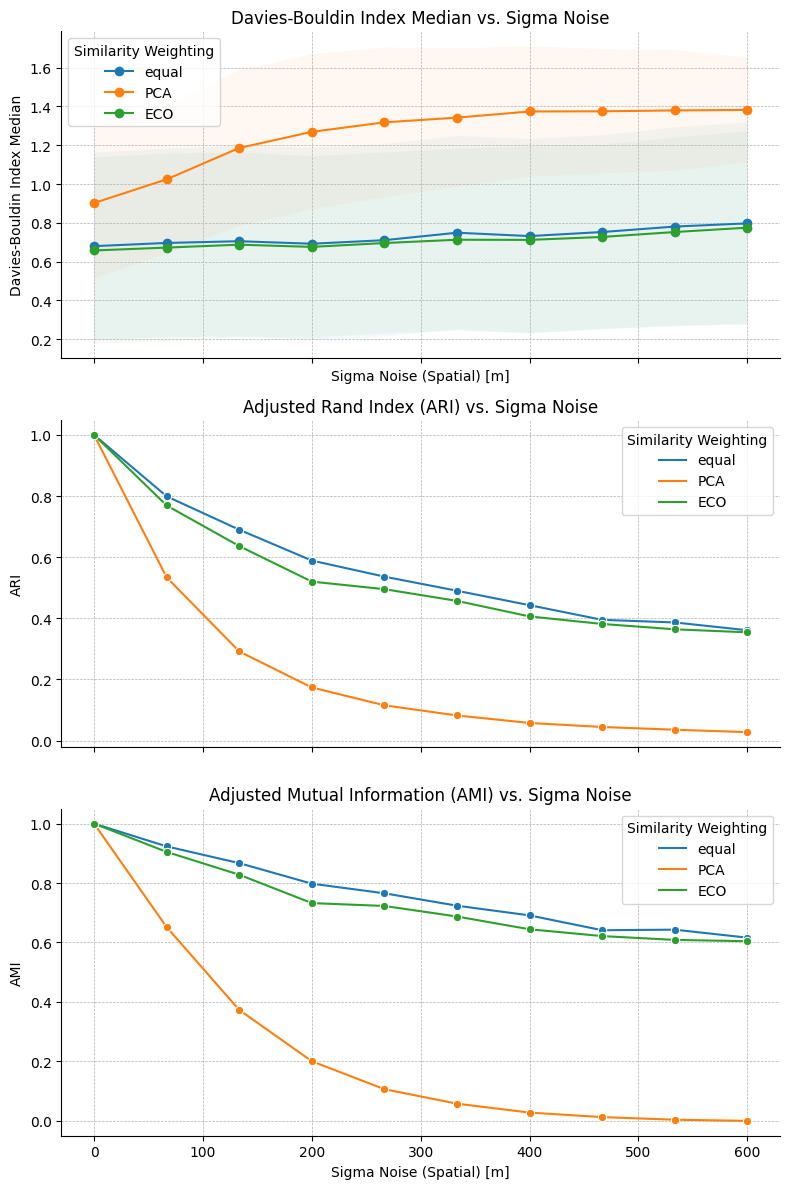

In [17]:
# Adjusting the plot to show the standard deviation as a shaded band for the Davies-Bouldin index and ensuring each subplot has its complete legend.
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
data = a
# For each clustering mode, plot the mean and std dev as a shaded area
for mode in data['clustering_mode'].unique():
    subset = data[data['clustering_mode'] == mode]
    # Davies-Bouldin Index with Std Dev as shaded area
    axes[0].plot(subset['sigma_noise_spatial'], subset['davies-bouldin_median'], marker='o', label=mode)
    axes[0].fill_between(subset['sigma_noise_spatial'], 
                         subset['davies-bouldin_median'] - subset['davies-bouldin_std'], 
                         subset['davies-bouldin_median'] + subset['davies-bouldin_std'], 
                         alpha=0.05)
axes[0].set_title('Davies-Bouldin Index Median vs. Sigma Noise')
axes[0].set_xlabel('Sigma Noise (Spatial) [m]')
axes[0].set_ylabel('Davies-Bouldin Index Median')
axes[0].legend(title='Similarity Weighting')

# ARI plot with complete legend
sns.lineplot(ax=axes[1], data=data, x='sigma_noise_spatial', y='ARI', hue='clustering_mode', marker='o', palette='tab10')
axes[1].set_title('Adjusted Rand Index (ARI) vs. Sigma Noise')
axes[1].set_xlabel('Sigma Noise (Spatial) [m]')
axes[1].set_ylabel('ARI')
axes[1].legend(title='Similarity Weighting')

# AMI plot with complete legend
sns.lineplot(ax=axes[2], data=data, x='sigma_noise_spatial', y='AMI', hue='clustering_mode', marker='o', palette='tab10')
axes[2].set_title('Adjusted Mutual Information (AMI) vs. Sigma Noise')
axes[2].set_xlabel('Sigma Noise (Spatial) [m]')
axes[2].set_ylabel('AMI')
axes[2].legend(title='Similarity Weighting')

for ax in axes:
    ax.grid(True, linestyle='--', lw=0.5)
    #drop spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()



In [18]:
fig.savefig('../figures/experience2.png', dpi=300, bbox_inches='tight')

# Experience 3 : DBSCAN and EPS

In [69]:
#load communities 
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


In [70]:
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
method = 'DBSCAN'
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

In [ ]:
from utils import translate_polygon
import warnings
import time
from joblib import Parallel, delayed
from itertools import islice
from sklearn.metrics import davies_bouldin_score, silhouette_score
from tqdm import tqdm
import os 

os.makedirs('../data/results/matrices', exist_ok=True)
os.makedirs('../data/results/labels', exist_ok=True)
os.makedirs('../data/results/clusters', exist_ok=True)

all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})
#grouping 
groups = all_clusters_gdf_v2.groupby('cluster')
std = np.std([len(g) for g in groups])
median = np.median([len(g) for g in groups])
eps_dx = np.linspace(0.15, 0.7, 12)
dict_reflabels = {}

#compute the foux matrices of similarities 
print(f'computing the four matrices for {len(groups)} communities...')
start = time.time()
list_matrices = []
with warnings.catch_warnings():
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for i in tqdm(range(0, len(groups), 1000)):
        r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_matrices_v2)(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict) for _,data in islice(groups, i, min(len(groups), i+1000)))
        list_matrices.extend(r)

end = time.time()
print(f'elapsed time : {end - start :.2f}s')

for mode in ['equal', 'PCA']:
    weight = weights[mode]
    #building all the similiarty matrix
    matrices = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(build_similarity_v2)(m, weight) for m in list_matrices)

    #save a list of matrices
    # np.save(f"../data/results/matrices/matrix_{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.npy", np.array(matrices))

    #clustering
    print('clustering with mode : ', mode)
    start = time.time()
    list_gdf = []
    list_labels = []
    list_sim_matrices = []
    for j in range(len(eps_dx)):
        #disturb time period and polygons 
        print('eps : ', eps_dx[j], '[1]')
        kwargs = {'eps': eps_dx[j], 'min_samples': 2}
        for i in tqdm(range(0, len(groups), 1000)):
            r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_cluster_v2)(data, m, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method, method_kwargs=kwargs) for (_,data), m in zip(islice(groups, i, min(len(groups), i+1000)), islice(matrices, i, min(len(matrices), i+1000))))
            for x in r:
                list_gdf.append(x[0])
                list_sim_matrices.append(x[1])
                list_labels.append(x[2])
        end = time.time()
        print(f'elapsed time : {end - start :.2f}s')

        #save labels
        # np.save(f"../data/results/labels/labels_DBSCAN_{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}_eps{eps_dx[j] :.2f}.npy", np.array(list_labels))

        #save gdf
        df = pd.concat(list_gdf)
        gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=attribution.dataset.crs)
        gdf.to_parquet(f"../data/results/clusters/clusters_DBSCAN_m{mode}_eps{eps_dx[j] :.2f}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")

        #compute silhouette score
        print('computing silhouette score...')
        silhouette_scores = []
        for similarity_matrix, labels in zip(list_sim_matrices, list_labels):
            # Ensure that labels have at least one cluster and less than n_samples clusters
            if 1 < len(set(labels)) < len(labels):
                # Convert similarity matrix to distance matrix if necessary
                distance_matrix = 1 - similarity_matrix
                
                # Calculate the Davies-Bouldin Score
                silhouette = silhouette_score(X=distance_matrix, labels=labels, metric='precomputed')
                silhouette_scores.append(silhouette)
    
        #label size
        #I want to know the size of each label in each l of list_labels
        label_size = [np.unique(l, return_counts=True)[1] for l in list_labels]
        #flatten the list
        label_size = [item for sublist in label_size for item in sublist]
   
        #count the number of label == -1 to know the noise level
        noise = sum([1 if -1 in l else 0 for l in list_labels]) / len(label_size)
        
        #label size without noise
        label_size = [np.unique([x for x in l if x!=-1], return_counts=True)[1] for l in list_labels]
        #flatten the list
        label_size = [item for sublist in label_size for item in sublist]
   

        #save the results
        if os.path.isfile('records.parquet'):
            old = gpd.read_parquet('records.parquet')
        else : 
            old = None

        #prepare a pandas dataframe with all the columns for all the parameters : 
        columns = ['geometry', 'version', 'spatial_threshold', 'temporal_threshold', 'n', 'm', 'c', 'resolution',
                    'communities_similarity', 'communities_mode', 'communities_size_median', 'communities_size_std',
                      'sigma_noise_spatial', 'sigma_noise_temporal', 
                      'clustering_method', 'clustering_method_params', 'clustering_similarity', 'clustering_mode', 'cluster_size_median', 'cluster_size_std', 'cluster_noise_perc',
                      'davies-bouldin_median', 'davies-bouldin_std', 'AMI', 'ARI', 'silhouette_median', 'silhouette_std', 
                      'exp']
        row1 = {'geometry': pol_4326, 
                'version': attribution.version, 
                'spatial_threshold': spatial_threshold, 
                'temporal_threshold': temporal_threshold, 
                'n': n, 'm': m, 'c': c, 
                'resolution': resolution, 
                'communities_similarity': '2d', 
                'communities_mode': 'equal', 
                'communities_size_median': median, 
                'communities_size_std': std, 
                'sigma_noise_spatial': 0, 
                'sigma_noise_temporal': 0, 
                'clustering_method': 'DBSCAN', 
                'clustering_method_params': f"{kwargs}", 
                'clustering_similarity': '4d', 
                'clustering_mode': mode,  
                'cluster_size_median': np.median(label_size),
                'cluster_size_std': np.std(label_size),
                'cluster_noise_perc': noise,
                'silhouette_median': np.median(silhouette_scores), 
                'silhouette_std': np.std(silhouette_scores),
                'exp': "3-silhouette-noise-size"}
        gdf = gpd.GeoDataFrame([row1], columns=columns, geometry='geometry', crs='epsg:2154')

        if old is not None:
            gdf = gpd.GeoDataFrame(pd.concat([old, gdf]), columns=columns, geometry='geometry', crs='epsg:2154').reset_index(drop=True)
        #save the dataframe
        gdf.exp = gdf.exp.astype(str)
        gdf.to_parquet(f"records.parquet")
    

### Analyse des résultats

In [1]:
import geopandas as gpd
records = gpd.read_parquet('records.parquet')
records['eps'] = records['clustering_method_params'].apply(lambda x : eval(x)['eps'] if x is not None else None)
cols = ['eps', 'clustering_mode', 'cluster_size_median', 'cluster_size_std', 'cluster_noise_perc', 'silhouette_median', 'silhouette_std']
a = records[ records['exp'] == '3-silhouette-noise-size'][cols]


In [2]:
a

,eps,clustering_mode,cluster_size_median,cluster_size_std,cluster_noise_perc,silhouette_median,silhouette_std
144,0.15,equal,3.0,6.072706,0.180352,0.383838,0.161861
145,0.20,equal,3.0,8.473904,0.183046,0.370429,0.163486
146,0.25,equal,3.0,10.998297,0.185519,0.385902,0.158916
147,0.30,equal,4.0,12.409988,0.183242,0.399509,0.155770
148,0.35,equal,4.0,13.323285,0.177237,0.407670,0.153879
149,0.40,equal,4.0,13.975956,0.169184,0.414541,0.152638
150,0.45,equal,4.0,14.465192,0.159635,0.417434,0.152172
151,0.50,equal,5.0,14.844152,0.148942,0.418822,0.152125
152,0.55,equal,5.0,15.142703,0.138855,0.419448,0.152189
153,0.60,equal,5.0,15.381641,0.129648,0.419552,0.152175


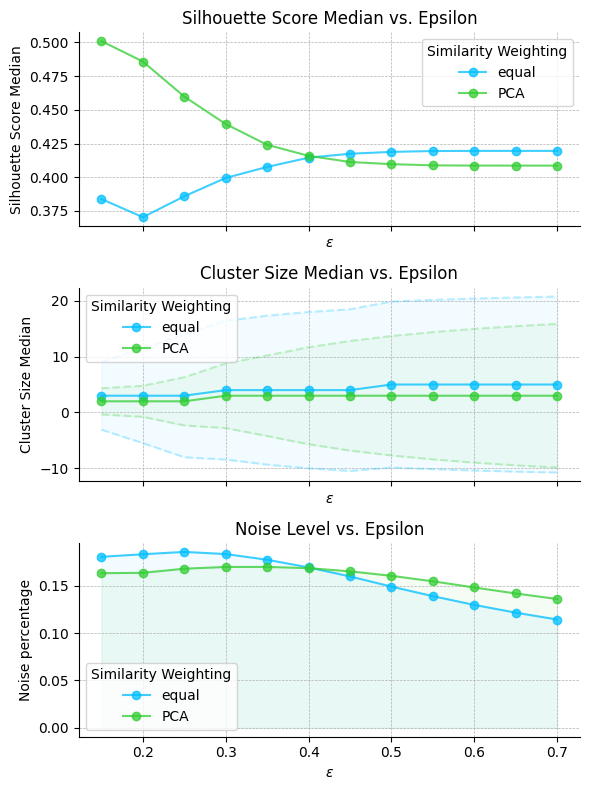

In [3]:
import matplotlib.pyplot as plt

# Define more contrasting colors for each configuration
colors = {'ECO': 'darkorange', 'equal': 'deepskyblue', 'PCA': 'limegreen'}

# Create a figure and a single subplot with updated colors
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
new_data = a 
# Plotting with the specified colors
for mode in new_data['clustering_mode'].unique():
    subset = new_data[new_data['clustering_mode'] == mode]
    axes[0].plot(subset['eps'], subset['silhouette_median'], label=mode, marker='o', color=colors[mode], alpha=0.75)
    #plot cluster_size median and std
    axes[1].plot(subset['eps'], subset['cluster_size_median'], label=mode, marker='o', color=colors[mode], alpha=0.75)
    #std 
    axes[1].fill_between(subset['eps'], 
                         subset['cluster_size_median'] - subset['cluster_size_std'], 
                         subset['cluster_size_median'] + subset['cluster_size_std'], 
                         alpha=0.05, color=colors[mode])
    #add dashed lines as enveloppe for the std
    axes[1].plot(subset['eps'], subset['cluster_size_median'] - subset['cluster_size_std'], linestyle='--', color=colors[mode], alpha=0.25)
    axes[1].plot(subset['eps'], subset['cluster_size_median'] + subset['cluster_size_std'], linestyle='--', color=colors[mode], alpha=0.25)

    #add noise level
    axes[2].plot(subset['eps'], subset['cluster_noise_perc'], label=mode, marker='o', color=colors[mode], alpha=0.75)
    #fill between 0 and cluster_noise_perc
    axes[2].fill_between(subset['eps'], 
                         0, 
                         subset['cluster_noise_perc'], 
                         alpha=0.05, color=colors[mode])


# Add a title and labels
axes[0].set_title('Silhouette Score Median vs. Epsilon')
axes[0].set_xlabel('$\epsilon$')
axes[0].set_ylabel('Silhouette Score Median')
axes[0].legend(title='Similarity Weighting')

axes[1].set_title('Cluster Size Median vs. Epsilon')
axes[1].set_xlabel('$\epsilon$')
axes[1].set_ylabel('Cluster Size Median')
axes[1].legend(title='Similarity Weighting')

axes[2].set_title('Noise Level vs. Epsilon')
axes[2].set_xlabel('$\epsilon$')
axes[2].set_ylabel('Noise percentage')
axes[2].legend(title='Similarity Weighting')

# Add a grid and show the plot
for ax in axes:
    ax.grid(True, linestyle='--', lw=0.5)
    #drop spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [4]:
fig.savefig('../figures/experience3.png', dpi=300, bbox_inches='tight')

# Experience 3 bis. Détermination de la valeur optimale de eps


In [24]:
#load communities 
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


In [28]:
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
method = 'DBSCAN'
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_k_distance(matrices, k=2):
    """
    Calculate the k-distance for each point in each community matrix.
    Args:
        matrices (list of np.ndarray): List of distance matrices for each community.
        k (int): The k-th nearest neighbor to consider, default is 2.
        
    Returns:
        list of np.ndarray: A list of k-distance values for each matrix.
    """
    k_distances = []
    for matrix in matrices:
        sorted_distances = np.sort(matrix, axis=1)[:, 1:k+1]  # Skip the first column as it is the distance to itself (0)
        k_dist = sorted_distances[:, -1]  # Get the k-th nearest distances
        k_distances.extend(k_dist)
    
    return k_distances


In [30]:
from utils import translate_polygon
import warnings
import time
from joblib import Parallel, delayed
from itertools import islice
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm
import os 

all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})
#grouping 
groups = all_clusters_gdf_v2.groupby('cluster')
std = np.std([len(g) for g in groups])
median = np.median([len(g) for g in groups])
eps_dx = np.linspace(0.15, 0.7, 12)
dict_reflabels = {}

#compute the foux matrices of similarities 
print(f'computing the four matrices for {len(groups)} communities...')
start = time.time()
list_matrices = []
with warnings.catch_warnings():
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for i in tqdm(range(0, len(groups), 1000)):
        r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_matrices_v2)(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict) for _,data in islice(groups, i, min(len(groups), i+1000)))
        list_matrices.extend(r)

end = time.time()
print(f'elapsed time : {end - start :.2f}s')

dict_kdistance = {}
for mode in ['equal', 'PCA']:
    weight = weights[mode]
    #building all the similiarty matrix
    matrices = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(build_similarity_v2)(m, weight) for m in list_matrices)

    #calculate k-distance
    print('computing k-distance...')
    dict_kdistance[mode] = calculate_k_distance(matrices, k=2)


    

computing the four matrices for 3709 communities...


  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_5729/2964155371.py:152: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_5729/2964155371.py:152: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_5729/2964155371.py:152: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the in

elapsed time : 71.44s
computing k-distance...
computing k-distance...


In [32]:
dict_kdistance.keys()

dict_keys(['equal', 'PCA'])

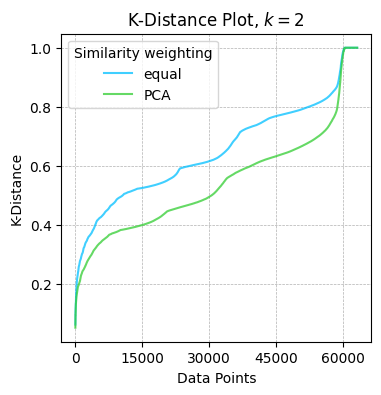

In [44]:
colors = {'ECO': 'darkorange', 'equal': 'deepskyblue', 'PCA': 'limegreen'}

#show less ticks on the x axis
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i, mode in enumerate(dict_kdistance):
    ax.plot(np.sort(dict_kdistance[mode]), label=mode, color=colors[mode], alpha=0.75)
ax.set_title('K-Distance Plot, $k=2$')
ax.set_xlabel('Data Points')
ax.set_ylabel('K-Distance')
ax.legend(title='Similarity weighting')
ax.grid(True, linestyle='--', lw=0.5)
ax.set_xticks(np.linspace(0, 60000, 5))
plt.show()

In [45]:
fig.savefig('../figures/experience3bis.png', dpi=300, bbox_inches='tight')

# Experience 4 : HDBSCAN 

In [2]:
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


In [3]:
from utils import compute_spatial_distance_v2, compute_tree_coherence_v2, compute_class_similarity_v2
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
kwds = {
    'DBSCAN': {'eps': 0.7, 'min_samples': 2},
    'HDBSCAN': {'min_cluster_size': 2}
}

method = 'DBSCAN'
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

In [ ]:
from utils import translate_polygon, get_cluster_v2, get_matrices_v2, build_similarity_v2
import warnings
import time
from joblib import Parallel, delayed
from itertools import islice
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from collections import defaultdict
import os 

all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})
N = 10
spatial_dx = 50 #m 
print('sigma level : ', spatial_dx, ' m')
dict_labels = defaultdict(list)
dict_labels_size = defaultdict(list)
dict_silhouette = defaultdict(list)
dict_noise = defaultdict(list)

for j in range(N):
    #disturb time period and polygons 
    if spatial_dx > 0:
        all_clusters_gdf_ = translate_polygon(all_clusters_gdf_v2.copy(), 'geometry', sigma=spatial_dx)
    else : 
        all_clusters_gdf_ = all_clusters_gdf_v2.copy()
    # all_clusters_gdf_ = translate_time(all_clusters_gdf.copy(), 'start_date', 'end_date', temporal_dx[j])

    #grouping 
    groups = all_clusters_gdf_.groupby('cluster')
    std = np.std([len(g) for g in groups])
    median = np.median([len(g) for g in groups])

    #compute the foux matrices of similarities 
    print(f'computing the four matrices for {len(groups)} communities...')
    start = time.time()
    list_matrices = []
    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        for i in tqdm(range(0, len(groups), 1000)):
            r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_matrices_v2)(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict) for _,data in islice(groups, i, min(len(groups), i+1000)))
            list_matrices.extend(r)

    end = time.time()
    print(f'elapsed time : {end - start :.2f}s')

    for mode in ['equal', 'PCA']:
        weight = weights[mode]
        #building all the similiarty matrix
        matrices = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(build_similarity_v2)(m, weight) for m in list_matrices)

        #disturb time period and polygons 
        list_gdf = []
        list_labels = []
        list_sim_matrices = []
        kwargs = kwds[method]
        for i in tqdm(range(0, len(groups), 1000)):
            r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_cluster_v2)(data, m, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method, method_kwargs=kwargs) for (_,data), m in zip(islice(groups, i, min(len(groups), i+1000)), islice(matrices, i, min(len(matrices), i+1000))))
            for x in r:
                list_gdf.append(x[0])
                list_sim_matrices.append(x[1])
                list_labels.append(x[2])
        end = time.time()
        print(f'elapsed time : {end - start :.2f}s')

        #save gdf
        df = pd.concat(list_gdf)
        gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=attribution.dataset.crs)
        gdf.to_parquet(f"../data/results/clusters/clusters_{method}_m{mode}_sn{spatial_dx}_{j}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")

        #SILHOUETTE SCORE
        print('computing silhouette score...')
        silhouette_scores = []
        for similarity_matrix, labels in zip(list_sim_matrices, list_labels):
            # Ensure that labels have at least one cluster and less than n_samples clusters
            if 1 < len(set(labels)) < len(labels):
                # Convert similarity matrix to distance matrix if necessary
                distance_matrix = 1 - similarity_matrix
                
                # Calculate the Davies-Bouldin Score
                silhouette = silhouette_score(X=distance_matrix, labels=labels, metric='precomputed')
                silhouette_scores.append(silhouette)
        dict_silhouette[mode].append(silhouette_scores)

        #LABELSIZE
        #I want to know the size of each label in each l of list_labels
        label_size = [np.unique(l, return_counts=True)[1] for l in list_labels]
        #flatten the list
        label_size = [item for sublist in label_size for item in sublist]
   
        #count the number of label == -1 to know the noise level
        noise = sum([1 if -1 in l else 0 for l in list_labels]) / len(label_size)
        dict_noise[mode].append(noise)
        
        #label size without noise
        label_size = [np.unique([x for x in l if x!=-1], return_counts=True)[1] for l in list_labels]
        #flatten the list
        label_size = [item for sublist in label_size for item in sublist]
        dict_labels_size[mode].append(label_size)
        
        #SAVE DATA FOR AMI AND ARI
        list_labels = []
        for row in tqdm(gdf.itertuples()):
            for id_ in row.Indexes:
                list_labels.append((id_, row.Index))
        df_label = pd.DataFrame(list_labels, columns=['id', 'label']).sort_values(by='id')
        dict_labels[mode].append(df_label)

        #save the results
        if os.path.isfile('records.parquet'):
            old = gpd.read_parquet('records.parquet')
        else : 
            old = None

        #prepare a pandas dataframe with all the columns for all the parameters : 
        columns = ['geometry', 'version', 'spatial_threshold', 'temporal_threshold', 'n', 'm', 'c', 'resolution',
                    'communities_similarity', 'communities_mode', 'communities_size_median', 'communities_size_std',
                      'sigma_noise_spatial', 'sigma_noise_temporal', 
                      'clustering_method', 'clustering_method_params', 'clustering_similarity', 'clustering_mode', 'cluster_size_median', 'cluster_size_std', 'cluster_noise_perc',
                      'davies-bouldin_median', 'davies-bouldin_std', 'AMI', 'ARI', 'silhouette_median', 'silhouette_std', 
                      'exp']
        row1 = {'geometry': pol_4326, 
                'version': attribution.version, 
                'spatial_threshold': spatial_threshold, 
                'temporal_threshold': temporal_threshold, 
                'n': n, 'm': m, 'c': c, 
                'resolution': resolution, 
                'communities_similarity': '2d', 
                'communities_mode': 'equal', 
                'communities_size_median': median, 
                'communities_size_std': std, 
                'sigma_noise_spatial': 0, 
                'sigma_noise_temporal': 0, 
                'clustering_method': method, 
                'clustering_method_params': f"{kwargs}", 
                'clustering_similarity': '4d', 
                'clustering_mode': mode,  
                'cluster_size_median': np.median(label_size),
                'cluster_size_std': np.std(label_size),
                'cluster_noise_perc': noise,
                'sigma_noise_spatial': spatial_dx, 
                'silhouette_median': np.median(silhouette_scores), 
                'silhouette_std': np.std(silhouette_scores),
                'exp': "4-silhouette-noise-size-ari-ami-N10"}
        gdf = gpd.GeoDataFrame([row1], columns=columns, geometry='geometry', crs='epsg:2154')

        if old is not None:
            gdf = gpd.GeoDataFrame(pd.concat([old, gdf]), columns=columns, geometry='geometry', crs='epsg:2154').reset_index(drop=True)
        #save the dataframe
        gdf.exp = gdf.exp.astype(str)
        gdf.to_parquet(f"records.parquet")

#save dict 
os.makedirs('../data/results/dict', exist_ok=True)
import pickle
with open(f'../data/results/dict/dict_labels_{method}_kwds{str(kwargs)}.pkl', 'wb') as f:
    pickle.dump(dict_labels, f)
with open(f'../data/results/dict/dict_labels_size_{method}_kwds{str(kwargs)}.pkl', 'wb') as f:
    pickle.dump(dict_labels_size, f)
with open(f'../data/results/dict/dict_silhouette_{method}_kwds{str(kwargs)}.pkl', 'wb') as f:
    pickle.dump(dict_silhouette, f)
with open(f'../data/results/dict/dict_noise_{method}_kwds{str(kwargs)}.pkl', 'wb') as f:
    pickle.dump(dict_noise, f)

## Analysis

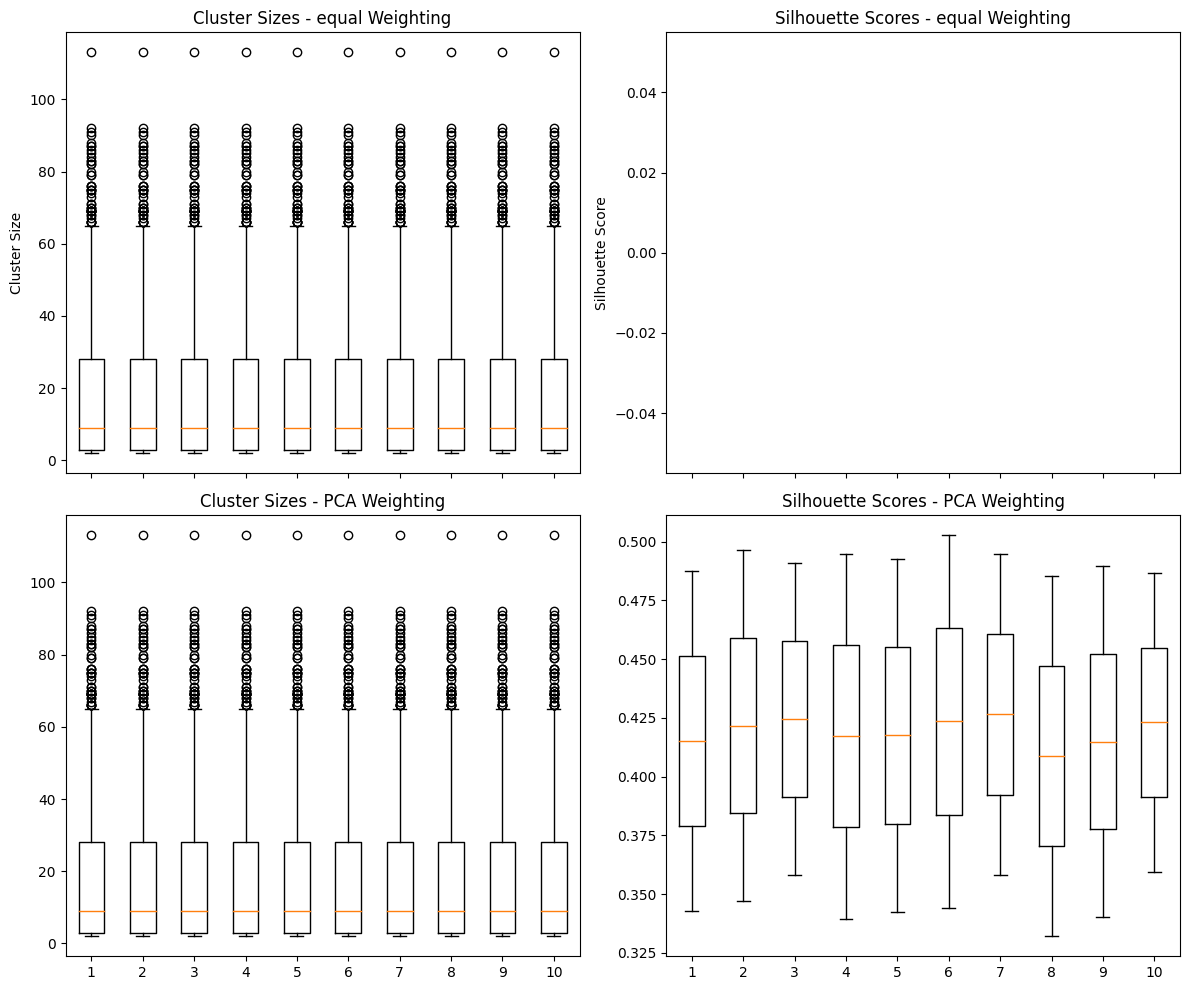

In [5]:
import matplotlib.pyplot as plt

# Function to plot distribution of cluster sizes and silhouette scores using boxplots
def plot_distributions(dict_labels_size, dict_silhouette):
    fig, axes = plt.subplots(2, len(dict_labels_size), figsize=(12, 10), sharex=True)
    
    # Plotting cluster sizes
    for i, (config, sizes_list) in enumerate(dict_labels_size.items()):
        axes[i, 0].boxplot(sizes_list)
        axes[i, 0].set_title(f'Cluster Sizes - {config} Weighting')
        axes[i, 0].set_xticks(range(1, len(sizes_list) + 1))
        axes[i, 0].set_xticklabels(range(1, len(sizes_list) + 1))
        if i == 0:
            axes[i, 0].set_ylabel('Cluster Size')

    # Plotting silhouette scores
    for i, (config, scores_list) in enumerate(dict_silhouette.items()):
        axes[i, 1].boxplot(scores_list)
        axes[i, 1].set_title(f'Silhouette Scores - {config} Weighting')
        axes[i, 1].set_xticks(range(1, len(scores_list) + 1))
        axes[i, 1].set_xticklabels(range(1, len(scores_list) + 1))
        if i == 0:
            axes[i, 1].set_ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()
    return fig

fig1 = plot_distributions(dict_labels_size, dict_silhouette)


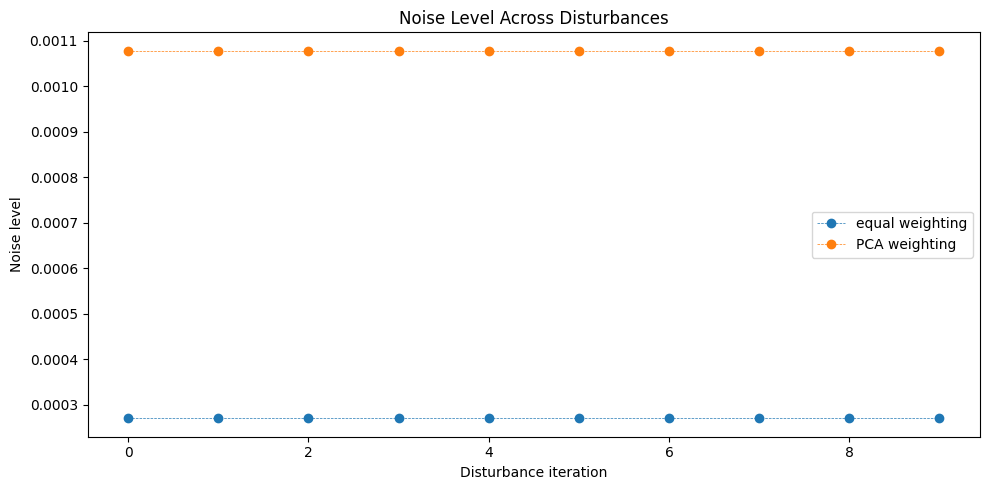

In [6]:
# Plotting noise level for each disturbance
def plot_noise_levels(noise_dict):
    fig, ax = plt.subplots(figsize=(10, 5))
    for config, noise_levels in noise_dict.items():
        ax.plot(noise_levels, label=f'{config} weighting', marker='o', linestyle='--', lw=0.5)
    ax.set_xlabel('Disturbance iteration')
    ax.set_ylabel('Noise level')
    ax.set_title('Noise Level Across Disturbances')
    ax.legend()
    plt.tight_layout()
    plt.show()
    return fig 

fig2 = plot_noise_levels(dict_noise)

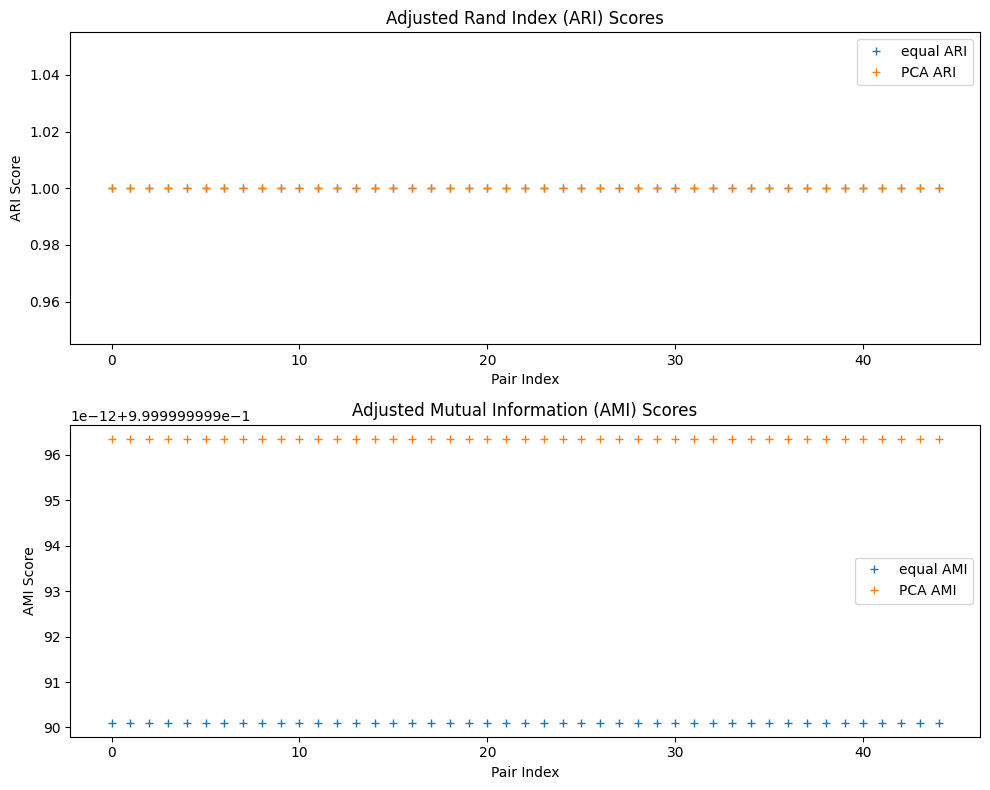

In [7]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Function to compute ARI or AMI scores across all pairs within each configuration
def compute_stability_scores(labels_dict, score_type='ARI'):
    scores_dict = defaultdict(list)
    for config, df_list in labels_dict.items():
        for i in range(len(df_list)):
            for j in range(i + 1, len(df_list)):
                labels_i = df_list[i]['label'].to_numpy()  # Assuming a 'label' column
                labels_j = df_list[j]['label'].to_numpy()
                if score_type == 'ARI':
                    score = adjusted_rand_score(labels_i, labels_j)
                else:  # AMI
                    score = adjusted_mutual_info_score(labels_i, labels_j)
                scores_dict[config].append(score)
    return scores_dict

# Example usage
ari_scores = compute_stability_scores(dict_labels, 'ARI')
ami_scores = compute_stability_scores(dict_labels, 'AMI')

# You can plot these scores similarly to the noise level plot, adjusting for multiple scores per configuration
def plot_stability_scores(ari_scores, ami_scores):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # ARI scores
    for config, scores in ari_scores.items():
        axes[0].plot(scores, label=f'{config} ARI', marker='+', linestyle='None')
    axes[0].set_title('Adjusted Rand Index (ARI) Scores')
    axes[0].set_xlabel('Pair Index')
    axes[0].set_ylabel('ARI Score')
    axes[0].legend()

    # AMI scores
    for config, scores in ami_scores.items():
        axes[1].plot(scores, label=f'{config} AMI', marker='+', linestyle='None')
    axes[1].set_title('Adjusted Mutual Information (AMI) Scores')
    axes[1].set_xlabel('Pair Index')
    axes[1].set_ylabel('AMI Score')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    return fig

fig3 = plot_stability_scores(ari_scores, ami_scores)


In [9]:
#save ari and ami scores in dict
os.makedirs('../data/results/dict', exist_ok=True)
import pickle
with open(f'../data/results/dict/ari_scores_{method}_kwds{str(kwargs)}.pkl', 'wb') as f:
    pickle.dump(ari_scores, f)
with open(f'../data/results/dict/ami_scores_{method}_kwds{str(kwargs)}.pkl', 'wb') as f:
    pickle.dump(ami_scores, f)
